In [1]:
import os
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
data_dir = "./data/proteins"

Create standardised datafiles for the spectra

In [3]:
for protein_folder in os.listdir(data_dir):
    predicted_spectrum_data = None  # Initialize to None
    experimental_spectrum_data = None  # Initialize to None

    for filename in os.listdir(os.path.join(data_dir, protein_folder)):
        if filename.endswith("csv"):
            try:
                predicted_spectrum_data = np.loadtxt(os.path.join(data_dir, protein_folder, filename), delimiter="\t")
            except Exception as e:
                print(f"Error loading predicted data from {filename}: {e}")

        if filename.endswith("dpt"):
            try:
                experimental_spectrum_data = np.loadtxt(os.path.join(data_dir, protein_folder, filename), delimiter="       ")
            except Exception as e:
                print(f"Error loading experimental data from {filename}: {e}")

    if predicted_spectrum_data is not None:
        # Save the predicted spectrum as a txt file
        np.savetxt(os.path.join(data_dir, protein_folder, "predicted.txt"), predicted_spectrum_data, delimiter="\t")

    if experimental_spectrum_data is not None:
        # Save the experimental spectrum as a txt file
        np.savetxt(os.path.join(data_dir, protein_folder, "experiment.txt"), experimental_spectrum_data, delimiter="\t")

Load the data

In [83]:
raw_spectra = defaultdict(lambda: {'predicted' : None, 'experimental' : None, 'corrected': None})
for protein_folder in os.listdir(data_dir):
    predicted_spectrum_data = None  # Initialize to None
    experimental_spectrum_data = None  # Initialize to None

    for filename in os.listdir(os.path.join(data_dir, protein_folder)):
        if filename.endswith("txt"):
            if filename == "predicted.txt":
                predicted_spectrum_data = np.loadtxt(os.path.join(data_dir, protein_folder, filename), delimiter="\t")
                raw_spectra[protein_folder]['predicted'] = predicted_spectrum_data
            elif filename == "experiment.txt":
                experimental_spectrum_data = np.loadtxt(os.path.join(data_dir, protein_folder, filename), delimiter="\t")
                raw_spectra[protein_folder]['experimental'] = experimental_spectrum_data
            else:
                print(f"Unexpected txt file: {filename}")

Normalise the data to the same scale, using the finer resolution data as the standard

In [84]:
length_of_spectrum_vector = 150
spectra = raw_spectra.copy()
for protein, protein_spectra in raw_spectra.items():
    # Identify the minimum and maximum wavenumber values for each spectrum
    predicted_wavenumber_min = protein_spectra['predicted'][:, 0].min()
    predicted_wavenumber_max = protein_spectra['predicted'][:, 0].max()
    experimental_wavenumber_min = protein_spectra['experimental'][:, 0].min()
    experimental_wavenumber_max = protein_spectra['experimental'][:, 0].max()

    # Identify the wavenumber overlap range
    overlap_min = max(predicted_wavenumber_min, experimental_wavenumber_min)
    overlap_max = min(predicted_wavenumber_max, experimental_wavenumber_max)

    # Crop the spectra to the overlap range
    predicted_spectrum_cropped = protein_spectra['predicted'][(protein_spectra['predicted'][:, 0] >= overlap_min) & (protein_spectra['predicted'][:, 0] <= overlap_max)]
    experimental_spectrum_cropped = protein_spectra['experimental'][(protein_spectra['experimental'][:, 0] >= overlap_min) & (protein_spectra['experimental'][:, 0] <= overlap_max)]

    max_min_wavenumber = max(min(predicted_spectrum_cropped[:, 0]), min(experimental_spectrum_cropped[:, 0]))
    min_max_wavenumber = min(max(predicted_spectrum_cropped[:, 0]), max(experimental_spectrum_cropped[:, 0]))
    # Identify the spectra with the highest wavenumber resolution
    predicted_resolution = np.diff(protein_spectra['predicted'][:, 0]).min()
    experimental_resolution = np.diff(protein_spectra['experimental'][:, 0]).min()

    # Set the wavenumbers to be the same for both spectra
    wavenumbers = np.linspace(min_max_wavenumber, max_min_wavenumber, length_of_spectrum_vector)

    # Interpolate the experimental spectrum 
    interpolation_function = interp1d(experimental_spectrum_cropped[:,0], experimental_spectrum_cropped[:,1], kind='linear')
    experimental_intensity_interpolated = interpolation_function(wavenumbers)
    experimental_spectrum_interpolated = np.column_stack((wavenumbers, experimental_intensity_interpolated))

    # Interpolate the cropped predicted spectrum 
    interpolation_function = interp1d(predicted_spectrum_cropped[:,0], predicted_spectrum_cropped[:,1], kind='linear')
    predicted_intensity_interpolated = interpolation_function(wavenumbers)
    predicted_spectrum_interpolated = np.column_stack((wavenumbers, predicted_intensity_interpolated))

    # Normalise the predicted spectrum intensity to have the same maximum value as the experimental spectrum
    predicted_spectrum_interpolated[:,1] = predicted_spectrum_interpolated[:,1] * experimental_spectrum_interpolated[:,1].max() / predicted_spectrum_interpolated[:,1].max()

    # Save the spectra
    spectra[protein] = {'predicted' : predicted_spectrum_interpolated, 'experimental' : experimental_spectrum_interpolated, 'corrected': None}

Define comparison metrics for two spectra

In [59]:
def same_scale(spectrum1, spectrum2):
    """
    Checks if the wavenumber scales of two spectra are the same.
    """
    return np.array_equal(spectrum1[:, 0], spectrum2[:, 0])

def spectrum_Lp_distance(spectrum1, spectrum2, p=1):
    """
    Calculates the Lp distance between two spectra.
    """
    if not same_scale(spectrum1, spectrum2):
        raise ValueError("Spectra must have the same wavenumber scale")
    
    return vector_Lp_distance(spectrum1[:, 1], spectrum2[:, 1], p=p)

def vector_Lp_distance(vector1, vector2, p=1):
    """
    Calculates the Lp distance between two vectors.
    """
    return np.sum(np.abs(vector1 - vector2)**p)**(1/p)

from sklearn.decomposition import PCA

def compute_PCA_distances(spectra, p=1, d=10, with_corrected=False):
    # Create a PCA instance
    pca = PCA(n_components=d)

    # Fit the PCA model to the space of experimental and theoretical spectra
    pca.fit(np.vstack([spectrum['experimental'][:, 1] for spectrum in spectra.values()] + [spectrum['predicted'][:, 1] for spectrum in spectra.values()]))

    # Transform the experimental and theoretical spectra into the PCA space
    experimental_spectra_pca = pca.transform(np.vstack([spectrum['experimental'][:, 1] for spectrum in spectra.values()]))
    predicted_spectra_pca = pca.transform(np.vstack([spectrum['predicted'][:, 1] for spectrum in spectra.values()]))
    if with_corrected:
        corrected_spectra_pca = pca.transform(np.vstack([spectrum['corrected'][:, 1] for spectrum in spectra.values()]))   
    else:
        corrected_spectra_pca = None    

    # Compute the Lp distance between the experimental and theoretical spectra in the PCA space
    Lp_PCA_distances = np.array([vector_Lp_distance(experimental_spectra_pca[i], predicted_spectra_pca[i], p=p) for i in range(len(experimental_spectra_pca))])
    
    return Lp_PCA_distances, experimental_spectra_pca, predicted_spectra_pca, corrected_spectra_pca

1) Plotting the spectra and annotating with distance metrics

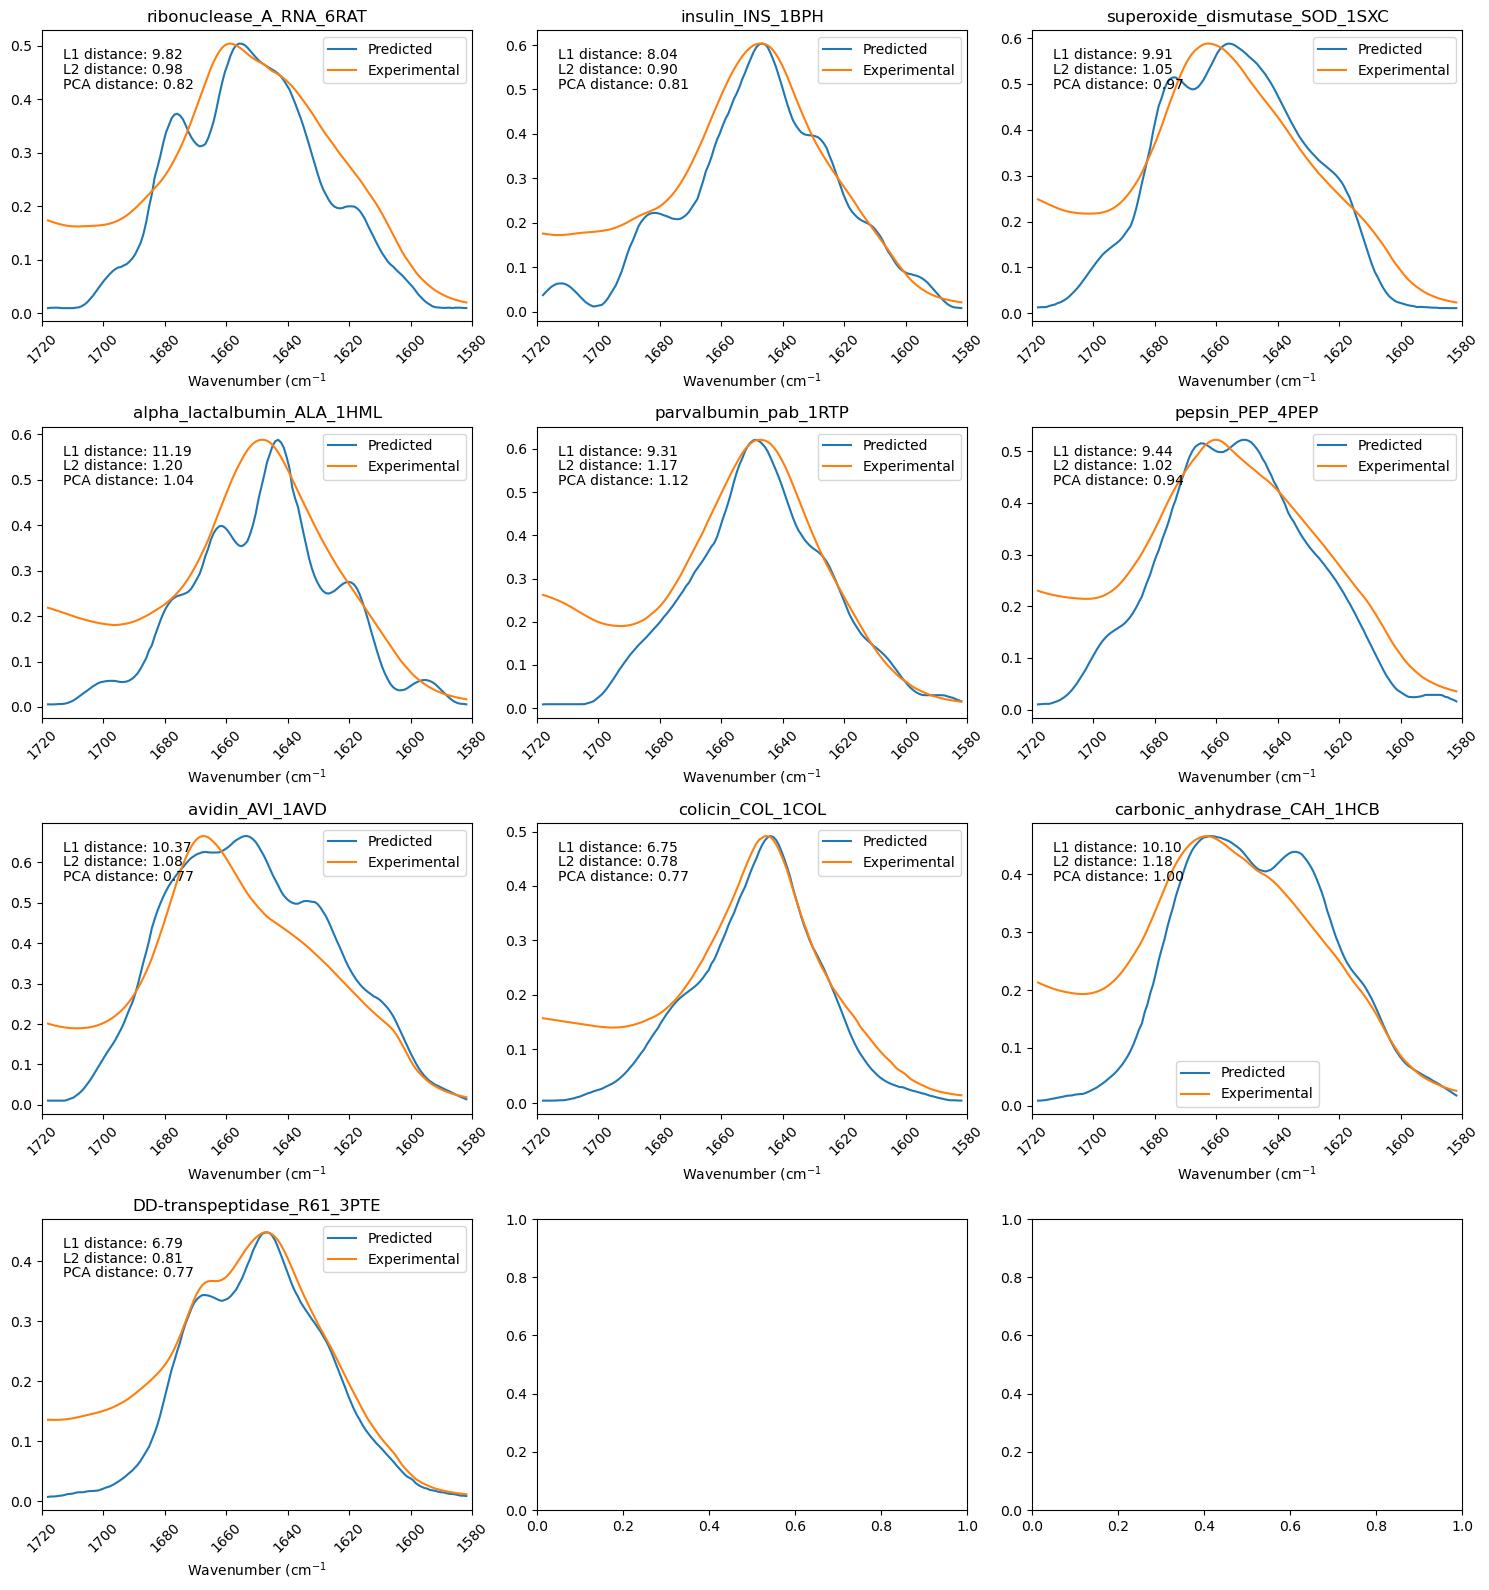

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectra_with_distances(spectra, L2_PCA_dists):
    num_columns = 3  # Number of columns for subplots
    num_rows = (len(spectra) + num_columns - 1) // num_columns  # Calculate the number of rows

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 4 * num_rows))

    for idx, (protein, protein_spectra) in enumerate(spectra.items()):
        row, col = divmod(idx, num_columns)
        ax = axes[row, col]

        # Calculate the L1 distance
        L1_dist = spectrum_Lp_distance(protein_spectra['predicted'], protein_spectra['experimental'], p=1)
        # Calculate the L2 distance
        L2_dist = spectrum_Lp_distance(protein_spectra['predicted'], protein_spectra['experimental'], p=2)

        # Flip x-axis labels
        x_values = protein_spectra['predicted'][:, 0][::-1]

        # Plot the spectra with flipped x-axis and labels
        ax.plot(x_values, protein_spectra['predicted'][:, 1], label="Predicted")
        ax.plot(x_values, protein_spectra['experimental'][:, 1], label="Experimental")
        if protein_spectra['corrected'] is not None:
            ax.plot(x_values, protein_spectra['corrected'][:, 1], label="Corrected")

        # Annotate the distances
        ax.annotate(f"L1 distance: {L1_dist:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
        ax.annotate(f"L2 distance: {L2_dist:.2f}", xy=(0.05, 0.85), xycoords='axes fraction')
        ax.annotate(f"PCA distance: {L2_PCA_dists[idx]:.2f}", xy=(0.05, 0.8), xycoords='axes fraction')

        # Set x-axis limits in reverse order
        ax.set_xlim(x_values[-1], x_values[0])

        # Select and plot integer x-axis labels
        integer_x_values = x_values[x_values == np.round(x_values)]  # Select integer values
        x_vals_to_plot = np.arange(round(min(x_values)-2), round(max(x_values)+10), 20)  # Select integer values to plot
        ax.set_xticks(x_vals_to_plot)
        ax.set_xticklabels(x_vals_to_plot, rotation=45)  # Rotate labels for readability
        ax.set_xlabel("Wavenumber (cm$^{-1}$")

        ax.set_title(protein)
        ax.legend()

    # Adjust subplot layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have already computed L2_PCA_dists and have your spectra defined
# plot_spectra_with_distances(spectra, L2_PCA_dists)
plot_spectra_with_distances(spectra, L2_PCA_dists)


2. PCA of the spectra and PCA distance between predicted and experimental spectra

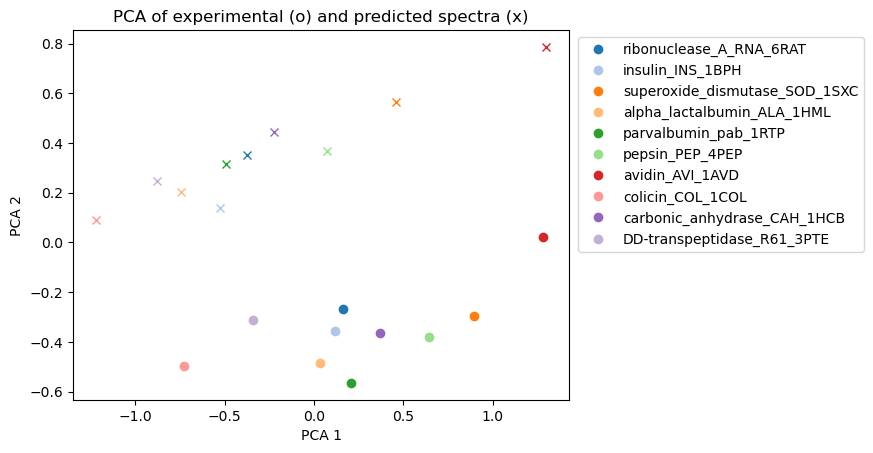

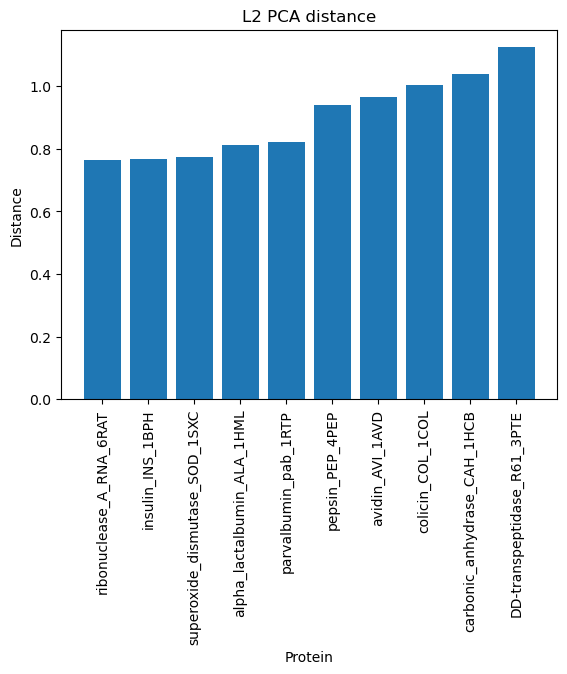

In [8]:
# For each protein, plot the two spectra and annotate on the diagram the L1, L2 and PCA distances
L2_PCA_dists, experiment_spectra_pca, predicted_spectra_pca = compute_PCA_distances(spectra, p=2, d=2)

# loop over the spectra pca values and plot them with the protein names
colour_map = plt.get_cmap('tab20')
for idx, (protein, protein_spectra) in enumerate(spectra.items()):
    plt.plot(experiment_spectra_pca[idx, 0], experiment_spectra_pca[idx, 1], 'o', color=colour_map(idx), label=protein)
    plt.plot(predicted_spectra_pca[idx, 0], predicted_spectra_pca[idx, 1], 'x', color=colour_map(idx))

plt.title("PCA of experimental (o) and predicted spectra (x)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.005, 1))
plt.show()

# Plot of proteins ranked by L2 PCA distance
plt.bar(range(len(L2_PCA_dists)), sorted(L2_PCA_dists))
plt.title("L2 PCA distance")
plt.xlabel("Protein")
plt.ylabel("Distance")
plt.xticks(range(len(L2_PCA_dists)), [protein for protein in spectra.keys()], rotation=90)
plt.show()


3. Nearest neighbour classifier in the PCA space

In [89]:
accuracy = []
print("Using PCA distance:")
for protein, predict_pca in zip(spectra.keys(), predicted_spectra_pca):
    # Find the experimental spectra with the smallest L2 distance to the predicted spectrum
    L2_distances = np.array([vector_Lp_distance(predict_pca, experiment_pca, p=2) for experiment_pca in experiment_spectra_pca])
    closest_experiment = list(spectra.keys())[np.argmin(L2_distances)]
    print(f"{protein} predicted closest to {closest_experiment} experimental")
    accuracy.append(closest_experiment == protein)
print("----------------------")
print(f"Accuracy: {np.mean(accuracy)}")
    

Using PCA distance:
ribonuclease_A_RNA_6RAT predicted closest to DD-transpeptidase_R61_3PTE experimental
insulin_INS_1BPH predicted closest to DD-transpeptidase_R61_3PTE experimental
superoxide_dismutase_SOD_1SXC predicted closest to ribonuclease_A_RNA_6RAT experimental
alpha_lactalbumin_ALA_1HML predicted closest to DD-transpeptidase_R61_3PTE experimental
parvalbumin_pab_1RTP predicted closest to DD-transpeptidase_R61_3PTE experimental
pepsin_PEP_4PEP predicted closest to ribonuclease_A_RNA_6RAT experimental
avidin_AVI_1AVD predicted closest to avidin_AVI_1AVD experimental
colicin_COL_1COL predicted closest to colicin_COL_1COL experimental
carbonic_anhydrase_CAH_1HCB predicted closest to DD-transpeptidase_R61_3PTE experimental
DD-transpeptidase_R61_3PTE predicted closest to colicin_COL_1COL experimental
----------------------
Accuracy: 0.2


4. Correlation between distance metrics

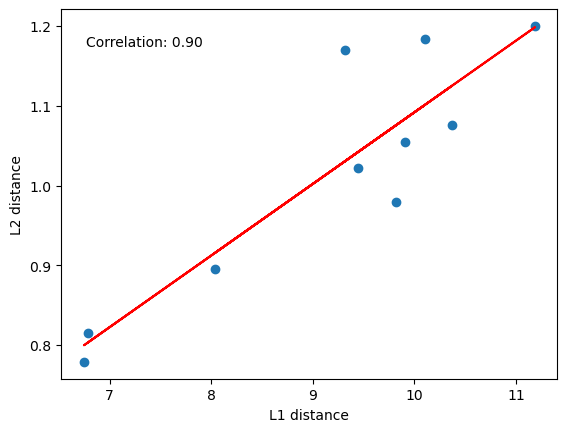

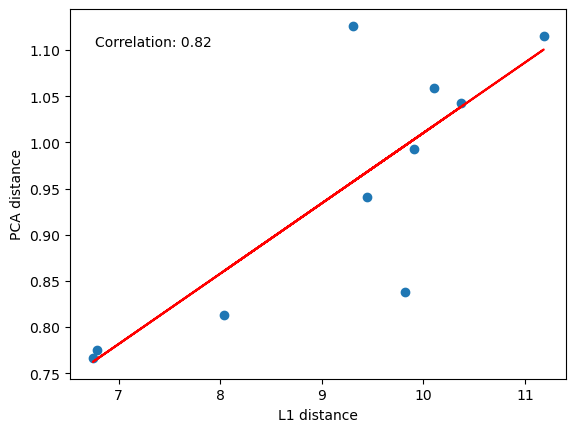

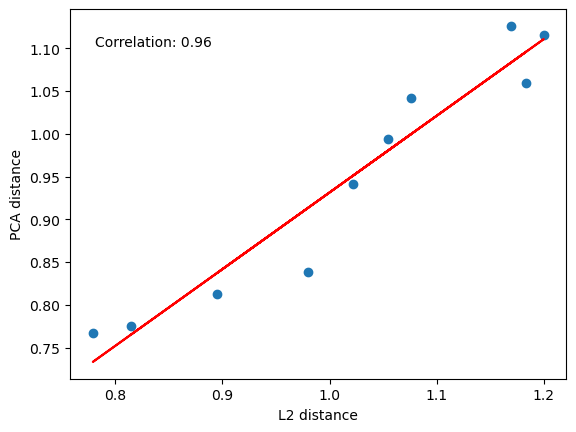

In [157]:
# Create a correlation plot of the different distance metrics
L1_dists = []
L2_dists = []
PCA_dists = compute_PCA_distances(spectra, p=2, d=3)[0]
for idx, (protein, protein_spectra) in enumerate(spectra.items()):
    # Calculate the L1 distance
    L1_dist = spectrum_Lp_distance(protein_spectra['predicted'], protein_spectra['experimental'], p=1)
    # Calculate the L2 distance
    L2_dist = spectrum_Lp_distance(protein_spectra['predicted'], protein_spectra['experimental'], p=2)

    L1_dists.append(L1_dist)
    L2_dists.append(L2_dist)

plt.scatter(L1_dists, L2_dists, label="L1 vs L2")
correlation = np.corrcoef(L1_dists, L2_dists)[0, 1]
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
line_of_best_fit = np.poly1d(np.polyfit(L1_dists, L2_dists, 1))
plt.plot(L1_dists, line_of_best_fit(L1_dists), color='red')
plt.xlabel("L1 distance")
plt.ylabel("L2 distance")
plt.show()
plt.scatter(L1_dists, PCA_dists, label="L1 vs PCA")
correlation = np.corrcoef(L1_dists, PCA_dists)[0, 1]
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
line_of_best_fit = np.poly1d(np.polyfit(L1_dists, PCA_dists, 1))
plt.plot(L1_dists, line_of_best_fit(L1_dists), color='red')
plt.xlabel("L1 distance")
plt.ylabel("PCA distance")
plt.show()
plt.scatter(L2_dists, PCA_dists, label="L2 vs PCA")
correlation = np.corrcoef(L2_dists, PCA_dists)[0, 1]
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.9), xycoords='axes fraction')
line_of_best_fit = np.poly1d(np.polyfit(L2_dists, PCA_dists, 1))
plt.plot(L2_dists, line_of_best_fit(L2_dists), color='red')
plt.xlabel("L2 distance")
plt.ylabel("PCA distance")
plt.show()

4. Exploring systematic difference between experimental and predicted spectra

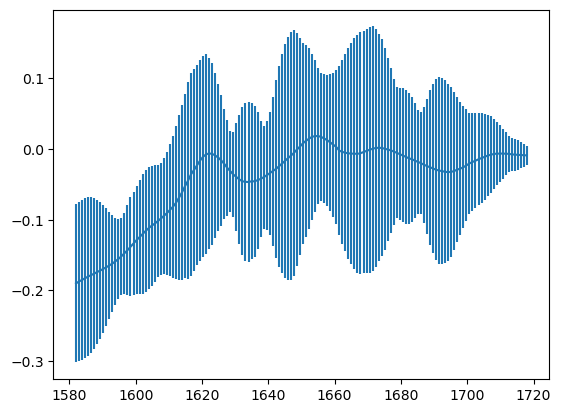

150
136.0
Sampling rate: 0.9066666666666666


In [58]:
# compute the mean difference between the experimental and predicted spectra as a function of wavenumber
mean_difference = np.zeros(len(spectra[list(spectra.keys())[0]]['predicted']))
for protein, protein_spectra in spectra.items():
    mean_difference += protein_spectra['predicted'][:, 1] - protein_spectra['experimental'][:, 1]
mean_difference /= len(spectra)
std_difference = np.zeros(len(spectra[list(spectra.keys())[0]]['predicted']))
for protein, protein_spectra in spectra.items():
    std_difference += np.sqrt((protein_spectra['predicted'][:, 1] - protein_spectra['experimental'][:, 1] - mean_difference)**2)
std_difference /= np.sqrt(len(spectra))

wavenumbers = spectra[list(spectra.keys())[0]]['predicted'][:, 0]
plt.errorbar(wavenumbers, mean_difference, yerr=std_difference)
plt.show()

print(len(wavenumbers))
print(max(wavenumbers) - min(wavenumbers))
print("Sampling rate:", (max(wavenumbers) - min(wavenumbers)) / len(wavenumbers))



Fitting a linear-exponential function to the mean difference between the experimental and predicted spectra as a function of wavenumber

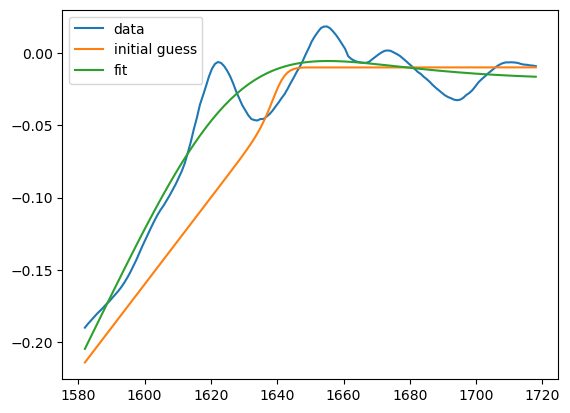

In [48]:
def f(x, a, b, c, d, e):
    return a * (x + b) * (1/(1+np.exp(c*(d-x)))) + e

p0 = [0.003, -1650, -0.5, 1640, -0.01]

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, wavenumbers, mean_difference, p0=p0)

# plot guess with initial parameters
plt.plot(wavenumbers, mean_difference, label='data')
plt.plot(wavenumbers, f(wavenumbers, *p0), label='initial guess')

# plot fit with final parameters
plt.plot(wavenumbers, f(wavenumbers, *popt), label='fit')
plt.legend()
plt.show()

correction_term = f(wavenumbers, *popt)


5. Plotting the corrected spectra

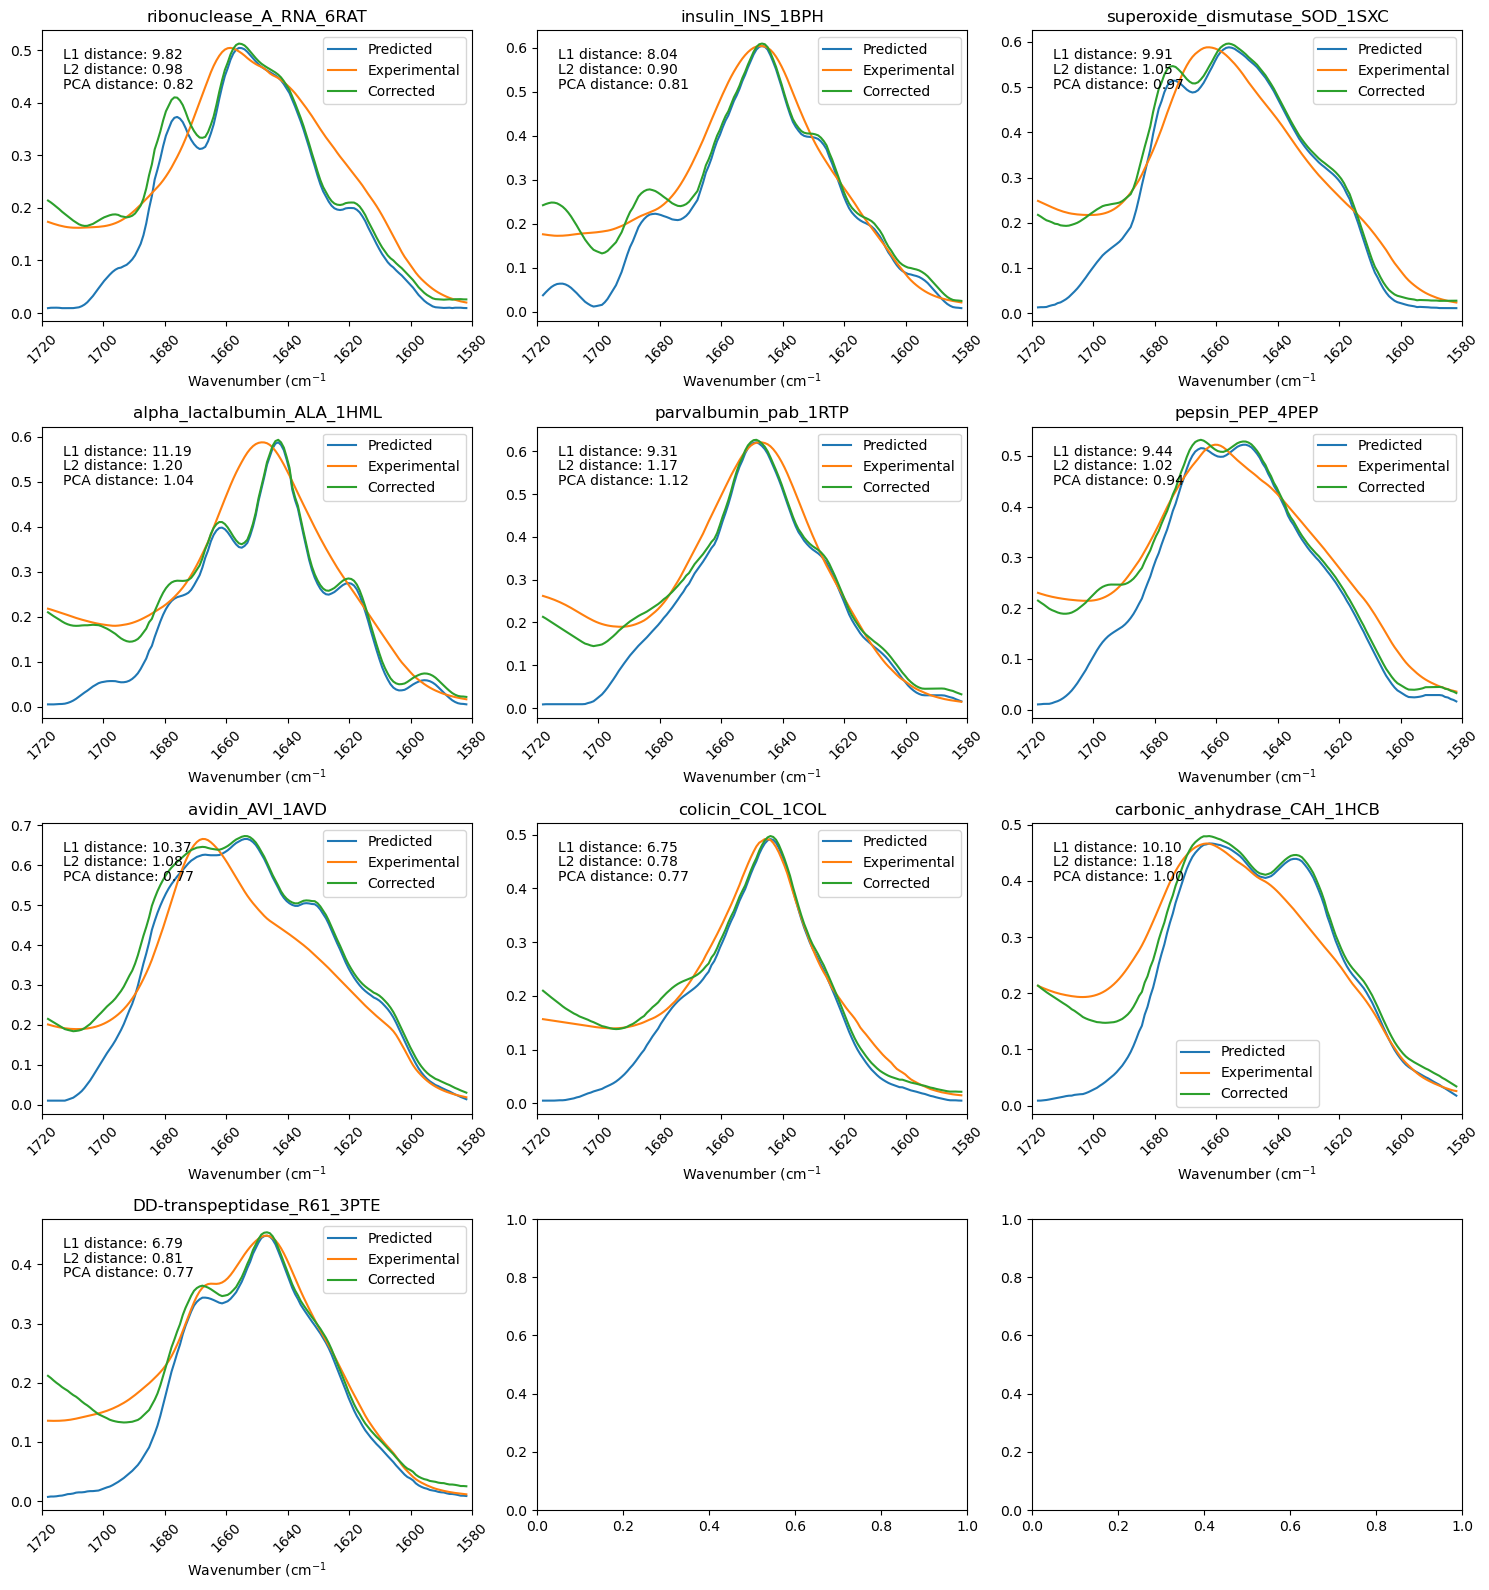

In [87]:
spectra_with_correction = spectra.copy()
for protein, protein_spectra in spectra_with_correction.items():
    protein_spectra['corrected'] = protein_spectra['predicted'].copy()
    protein_spectra['corrected'][:, 1] -= correction_term

plot_spectra_with_distances(spectra_with_correction, L2_PCA_dists)

6. Recomputing the PCA embeddings

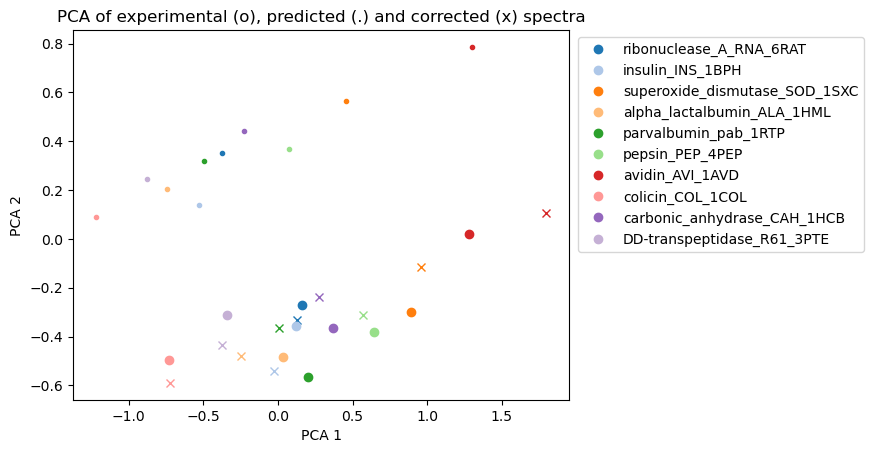

In [90]:
# PCA plot with correction term
# For each protein, plot the two spectra and annotate on the diagram the L1, L2 and PCA distances
L2_PCA_dists, experiment_spectra_pca, predicted_spectra_pca, corrected_spectra_pca = compute_PCA_distances(spectra_with_correction, p=2, d=2, with_corrected=True)

# loop over the spectra pca values and plot them with the protein names
colour_map = plt.get_cmap('tab20')
for idx, (protein, protein_spectra) in enumerate(spectra_with_correction.items()):
    plt.plot(experiment_spectra_pca[idx, 0], experiment_spectra_pca[idx, 1], 'o', color=colour_map(idx), label=protein)
    plt.plot(predicted_spectra_pca[idx, 0], predicted_spectra_pca[idx, 1], '.', color=colour_map(idx))
    plt.plot(corrected_spectra_pca[idx, 0], corrected_spectra_pca[idx, 1], 'x', color=colour_map(idx))

plt.title("PCA of experimental (o), predicted (.) and corrected (x) spectra")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(bbox_to_anchor=(1.005, 1))
plt.show()

7. A nearest neighbour classifier using the corrected spectra

In [91]:
accuracy = []
print("Using PCA distance:")
for protein, corrected_pca in zip(spectra.keys(), corrected_spectra_pca):
    # Find the experimental spectra with the smallest L2 distance to the predicted spectrum
    L2_distances = np.array([vector_Lp_distance(corrected_pca, experiment_pca, p=2) for experiment_pca in experiment_spectra_pca])
    closest_experiment = list(spectra.keys())[np.argmin(L2_distances)]
    print(f"{protein} predicted closest to {closest_experiment} experimental")
    accuracy.append(closest_experiment == protein)
print("----------------------")
print(f"Accuracy: {np.mean(accuracy)}")

Using PCA distance:
ribonuclease_A_RNA_6RAT predicted closest to insulin_INS_1BPH experimental
insulin_INS_1BPH predicted closest to alpha_lactalbumin_ALA_1HML experimental
superoxide_dismutase_SOD_1SXC predicted closest to superoxide_dismutase_SOD_1SXC experimental
alpha_lactalbumin_ALA_1HML predicted closest to DD-transpeptidase_R61_3PTE experimental
parvalbumin_pab_1RTP predicted closest to insulin_INS_1BPH experimental
pepsin_PEP_4PEP predicted closest to pepsin_PEP_4PEP experimental
avidin_AVI_1AVD predicted closest to avidin_AVI_1AVD experimental
colicin_COL_1COL predicted closest to colicin_COL_1COL experimental
carbonic_anhydrase_CAH_1HCB predicted closest to ribonuclease_A_RNA_6RAT experimental
DD-transpeptidase_R61_3PTE predicted closest to DD-transpeptidase_R61_3PTE experimental
----------------------
Accuracy: 0.5
